<img src="../../images/airplane-symbol.jpg" style="float: left; margin: 20px;" width="50" height="50"> 
#  Predicting Flight Delays (<i>a Proof-of-Concept</i>)

Author: Solomon Heng

---

# Regression Modeling (all routes)

## Processes covered in this notebook:
1. [Importing dataset](#(1)-Importing-dataset)
2. [Setting X_train, X_test, y_train & y_test](#(2)-Setting-X_train,-X_test,-y_train-&-y_test)
3. [Model (I): Linear Regression](#(3)-Model-(I):-Linear-Regression)
4. [Model (II): RandomForest](#(4)-Model-(II):-RandomForest)
5. [Model (III): XGBoost](#(5)-Model-(III):-XGBoost)
6. [Model (IV): Neural Networks](#(6)-Model-(IV):-Neural-Networks)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K

import xgboost as xgb

import pickle

from yellowbrick.regressor import ResidualsPlot

sns.set()

Using TensorFlow backend.
C:\Users\solom\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


---
### (1) Importing dataset

---

In [2]:
df = pd.read_csv('../datasets/combined_data_regression.csv')
df_test = pd.read_csv('../datasets/combined_data_regression_test.csv')

In [3]:
pd.set_option('display.max_columns', 100)
df.head()

,DEPARTURE_DELAY,lightning,shower,snow,squall,thunderyshower,DEPARTURE_DELAY^2,DEPARTURE_DELAY SCHEDULED_TIME,DEPARTURE_DELAY DISTANCE,DEPARTURE_DELAY QNH,DEPARTURE_DELAY dew_point,DEPARTURE_DELAY visibility,DEPARTURE_DELAY temp,DEPARTURE_DELAY winddir,DEPARTURE_DELAY windspd,DEPARTURE_DELAY NUM_ARR_AVG_3HOUR,DEPARTURE_DELAY crosswind_comp,SCHEDULED_ARRIVAL_MONTH_11,SCHEDULED_ARRIVAL_MONTH_12,SCHEDULED_ARRIVAL_MONTH_2,SCHEDULED_ARRIVAL_MONTH_3,SCHEDULED_ARRIVAL_MONTH_4,SCHEDULED_ARRIVAL_MONTH_5,SCHEDULED_ARRIVAL_MONTH_6,SCHEDULED_ARRIVAL_MONTH_7,SCHEDULED_ARRIVAL_MONTH_8,SCHEDULED_ARRIVAL_MONTH_9,SCHEDULED_ARRIVAL_HOUR_1,SCHEDULED_ARRIVAL_HOUR_10,SCHEDULED_ARRIVAL_HOUR_11,SCHEDULED_ARRIVAL_HOUR_12,SCHEDULED_ARRIVAL_HOUR_13,SCHEDULED_ARRIVAL_HOUR_14,SCHEDULED_ARRIVAL_HOUR_15,SCHEDULED_ARRIVAL_HOUR_16,SCHEDULED_ARRIVAL_HOUR_17,SCHEDULED_ARRIVAL_HOUR_18,SCHEDULED_ARRIVAL_HOUR_19,SCHEDULED_ARRIVAL_HOUR_2,SCHEDULED_ARRIVAL_HOUR_20,SCHEDULED_ARRIVAL_HOUR_21,SCHEDULED_ARRIVAL_HOUR_22,SCHEDULED_ARRIVAL_HOUR_23,SCHEDULED_ARRIVAL_HOUR_3,SCHEDULED_ARRIVAL_HOUR_4,SCHEDULED_ARRIVAL_HOUR_5,SCHEDULED_ARRIVAL_HOUR_6,SCHEDULED_ARRIVAL_HOUR_7,SCHEDULED_ARRIVAL_HOUR_8,SCHEDULED_ARRIVAL_HOUR_9,...,ORIGIN_AIRPORT_ORF,ORIGIN_AIRPORT_PBI,ORIGIN_AIRPORT_PDX,ORIGIN_AIRPORT_PHF,ORIGIN_AIRPORT_PHL,ORIGIN_AIRPORT_PHX,ORIGIN_AIRPORT_PIA,ORIGIN_AIRPORT_PIT,ORIGIN_AIRPORT_PNS,ORIGIN_AIRPORT_PVD,ORIGIN_AIRPORT_PWM,ORIGIN_AIRPORT_RAP,ORIGIN_AIRPORT_RDU,ORIGIN_AIRPORT_RIC,ORIGIN_AIRPORT_ROA,ORIGIN_AIRPORT_ROC,ORIGIN_AIRPORT_RST,ORIGIN_AIRPORT_RSW,ORIGIN_AIRPORT_SAN,ORIGIN_AIRPORT_SAT,ORIGIN_AIRPORT_SAV,ORIGIN_AIRPORT_SBN,ORIGIN_AIRPORT_SCE,ORIGIN_AIRPORT_SDF,ORIGIN_AIRPORT_SEA,ORIGIN_AIRPORT_SFO,ORIGIN_AIRPORT_SGF,ORIGIN_AIRPORT_SHV,ORIGIN_AIRPORT_SJC,ORIGIN_AIRPORT_SJU,ORIGIN_AIRPORT_SLC,ORIGIN_AIRPORT_SMF,ORIGIN_AIRPORT_SNA,ORIGIN_AIRPORT_SRQ,ORIGIN_AIRPORT_STL,ORIGIN_AIRPORT_STT,ORIGIN_AIRPORT_STX,ORIGIN_AIRPORT_SYR,ORIGIN_AIRPORT_TLH,ORIGIN_AIRPORT_TPA,ORIGIN_AIRPORT_TRI,ORIGIN_AIRPORT_TTN,ORIGIN_AIRPORT_TUL,ORIGIN_AIRPORT_TUS,ORIGIN_AIRPORT_TVC,ORIGIN_AIRPORT_TYS,ORIGIN_AIRPORT_VLD,ORIGIN_AIRPORT_VPS,ORIGIN_AIRPORT_XNA,ARRIVAL_DELAY
0,2.535036,0.096701,0.310413,0.221437,-0.760361,0.096701,0.550227,1.535834,0.596509,2.521420,3.319960,2.803339,3.518770,2.804263,2.340842,2.597767,2.232348,-0.315111,-0.308782,-0.289299,-0.325409,-0.316162,-0.321104,3.118630,-0.329611,-0.328894,-0.317112,-0.017317,-0.225468,-0.249137,-0.229945,-0.250615,-0.289551,-0.278578,-0.251898,-0.206389,-0.285744,3.489136,-0.004684,-0.252423,-0.239934,-0.149888,-0.105059,-0.001912,-0.018343,-0.066715,-0.149275,-0.224706,-0.302439,-0.282686,...,-0.088277,-0.111016,-0.05626,-0.059286,-0.139334,-0.102631,-0.050217,-0.097774,-0.081459,-0.052925,-0.041533,-0.006894,-0.117806,-0.101497,-0.065431,-0.053718,-0.030667,-0.107313,-0.076369,-0.091562,-0.095986,-0.057744,-0.010647,-0.088696,-0.089489,-0.095577,-0.061,-0.076684,-0.028565,-0.063486,-0.086963,-0.040414,-0.052786,-0.075321,-0.101681,-0.042147,-0.010647,-0.05334,-0.078094,-0.14398,-0.074804,-0.030003,-0.066908,-0.04219,-0.009561,-0.070376,-0.051943,-0.080957,-0.067101,93.0
1,-0.182679,0.096701,0.310413,0.221437,1.315165,0.096701,-0.088523,-0.168052,-0.149166,-0.182426,-0.158143,-0.158233,-0.172347,-0.175560,-0.165134,-0.169318,-0.155071,3.173483,-0.308782,-0.289299,-0.325409,-0.316162,-0.321104,-0.320654,-0.329611,-0.328894,-0.317112,-0.017317,-0.225468,-0.249137,-0.229945,-0.250615,-0.289551,-0.278578,-0.251898,-0.206389,-0.285744,-0.286604,-0.004684,-0.252423,-0.239934,-0.149888,-0.105059,-0.001912,-0.018343,-0.066715,-0.149275,-0.224706,3.306454,-0.282686,...,-0.088277,-0.111016,-0.05626,-0.059286,-0.139334,-0.102631,-0.050217,-0.097774,-0.081459,-0.052925,-0.041533,-0.006894,-0.117806,-0.101497,-0.065431,-0.053718,-0.030667,-0.107313,-0.076369,-0.091562,-0.095986,-0.057744,-0.010647,-0.088696,-0.089489,-0.095577,-0.061,-0.076684,-0.028565,-0.063486,-0.086963,-0.040414,-0.052786,-0.075321,-0.101681,-0.042147,-0.010647,-0.05334,-0.07809

In [4]:
df.shape

(273520, 228)

In [5]:
# Only looking at delayed flights
df = df[df['ARRIVAL_DELAY']>=15]
df_test = df_test[df_test['ARRIVAL_DELAY']>=15]

In [7]:
df.ARRIVAL_DELAY.mean()

65.46372141122147

In [8]:
df_test.ARRIVAL_DELAY.mean()

66.5834871296746

---
### (2) Setting X_train, X_test, y_train & y_test

---

In [9]:
X_train = df.drop('ARRIVAL_DELAY', axis=1)
y_train = df['ARRIVAL_DELAY']
X_test = df_test.drop('ARRIVAL_DELAY', axis=1)
y_test = df_test['ARRIVAL_DELAY']

In [10]:
X_train.shape

(41581, 227)

In [11]:
X_test.shape

(10295, 227)

---
### (3) Model (I): Linear Regression

---

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
np.sqrt(-cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error').mean())

61083462575385.92

In [14]:
# R^2 Score
lr.score(X_test, y_test)

0.9516288216561947

In [15]:
# RMSE Score
np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))

17.767567209024698

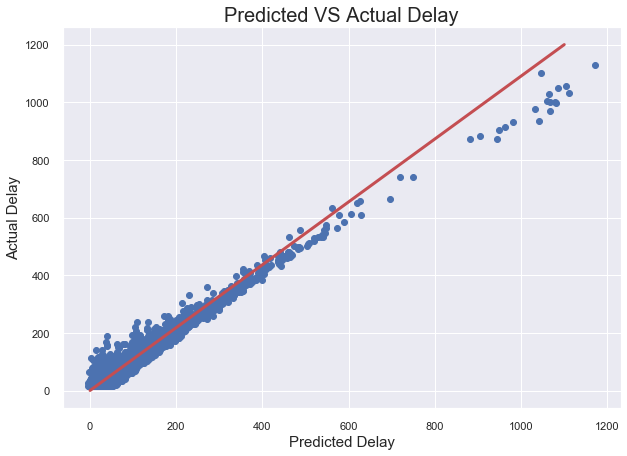

In [16]:
# Visualizing our Predictions vs Actual
pred = lr.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((0,1100), (0, 1200), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

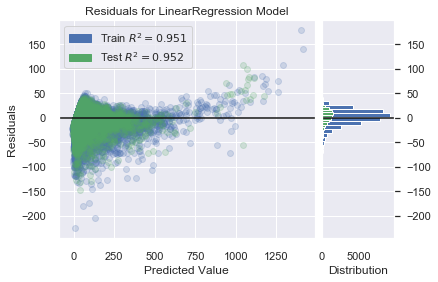

In [17]:
# Visualizing distribution of errors

visualizer = ResidualsPlot(lr, train_alpha=0.2, test_alpha=0.2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

In [18]:
# Exporting model

# lr_filename = '../models/regression_lr_model.sav'
# pickle.dump(lr, open(lr_filename, 'wb'))

---
### (4) Model (II): RandomForest

---

In [19]:
rf = RandomForestRegressor()

In [20]:
rf_params = {
  "n_estimators":[50,100],
  "min_samples_split":[10,20],
  "max_depth":[5,10]
}

rf_cv = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=2, n_jobs=4, verbose=2)

In [21]:
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [22]:
rf_cv.best_params_

{'n_estimators': 50, 'min_samples_split': 10, 'max_depth': 10}

In [23]:
opt_rf = RandomForestRegressor(n_estimators=50, min_samples_split=10, max_depth=10) # CHANGE TO 100, 20, 10 PLS -SOLO

In [24]:
opt_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [25]:
np.sqrt(-cross_val_score(opt_rf, X_train, y_train, scoring='neg_mean_squared_error').mean())

15.370280751156113

In [26]:
# R^2 Score
opt_rf.score(X_test, y_test)

0.9632300295009973

In [27]:
# RMSE Score
np.sqrt(mean_squared_error(y_test, opt_rf.predict(X_test)))

15.491064922769636

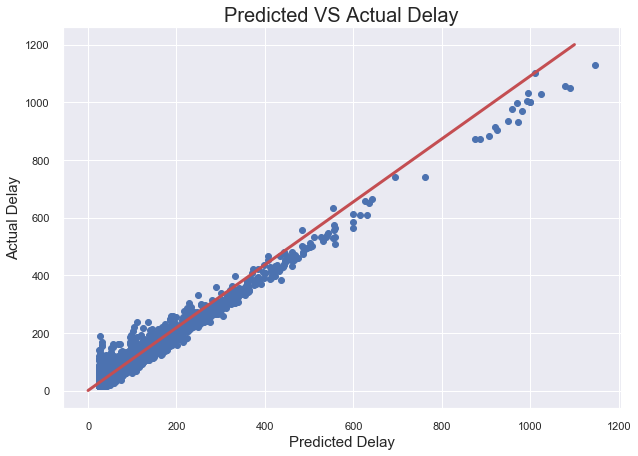

In [28]:
# Visualizing our Predictions vs Actual
pred = opt_rf.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((0,1100), (0, 1200), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

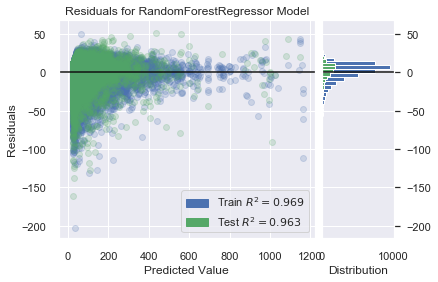

In [29]:
# Visualizing distribution of errors

visualizer = ResidualsPlot(opt_rf, train_alpha=0.2, test_alpha=0.2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

In [30]:
# Exporting model

# rf_filename = '../models/regression_rf_model.sav'
# pickle.dump(opt_rf, open(rf_filename, 'wb'))

---
### (5) Model (III): XGBoost

---

In [31]:
xgbr = xgb.XGBRegressor()

In [32]:
xgbr_params = {
  "learning_rate":[0.01, 0.1, 0.2, 0.3],
  "max_depth":[3, 5, 10]
}

xgbr_cv = RandomizedSearchCV(xgbr, param_distributions=xgbr_params, n_iter=2, n_jobs=4, verbose=2)

In [33]:
xgbr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  4.2min finished
C:\Users\solom\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\solom\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:14:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                               

In [34]:
xgbr_cv.best_params_

{'max_depth': 10, 'learning_rate': 0.2}

In [35]:
opt_xgb = xgb.XGBRegressor(max_depth=10, learning_rate=0.1)

In [36]:
opt_xgb.fit(X_train, y_train)

[16:16:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [37]:
np.sqrt(-cross_val_score(opt_xgb, X_train, y_train, scoring='neg_mean_squared_error').mean())

[16:17:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\solom\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:18:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\solom\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\solom\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:21:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\solom\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


15.087213193466438

In [38]:
# R^2 Score
opt_xgb.score(X_test, y_test)

0.9645867942409626

In [39]:
# RMSE Score
np.sqrt(mean_squared_error(y_test, opt_xgb.predict(X_test)))

15.202578504549082

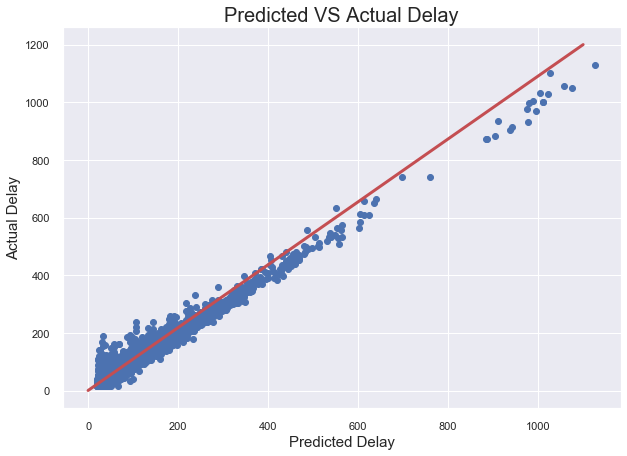

In [40]:
# Visualizing our Predictions vs Actual
pred = opt_xgb.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((0,1100), (0, 1200), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

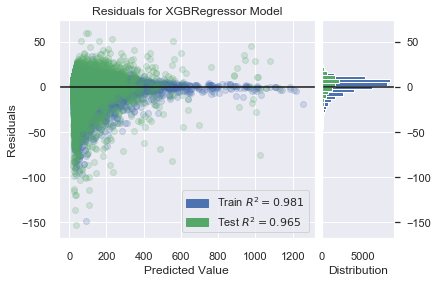

In [41]:
# Visualizing distribution of errors

visualizer = ResidualsPlot(opt_xgb, train_alpha=0.2, test_alpha=0.2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

In [42]:
# Exporting model

# xgb_filename = '../models/regression_xgb_model.sav'
# pickle.dump(opt_xgb, open(xgb_filename, 'wb'))

---
### (6) Model (IV): Neural Networks

---

In [43]:
model = Sequential()

In [44]:
model.add(Dense(200, 
                input_dim=227, 
                activation='relu'))

# model.add(Dropout(0.5))

model.add(Dense(200, 
                activation='relu'))

#model.add(Dropout(0.5))

#model.add(Dense(150, 
                #activation='relu'))

# Can include dropout (Nope, performed poorer)

model.add(Dense(1))

In [45]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [46]:
es = EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mse', 'mae'])

In [47]:
model.fit(X_train, y_train, batch_size=512, epochs=1000, validation_split=0.2, callbacks=[es])

Train on 33264 samples, validate on 8317 samples
Epoch 1/1000
33264/33264 [==============================] - 1s 31us/step - loss: 56.9525 - mse: 4140.2407 - mae: 35.3990 - val_loss: 22.9499 - val_mse: 531.2148 - val_mae: 15.9051
Epoch 2/1000
33264/33264 [==============================] - 1s 16us/step - loss: 22.1772 - mse: 506.3882 - mae: 14.6178 - val_loss: 19.4445 - val_mse: 381.0486 - val_mae: 13.4720
Epoch 3/1000
33264/33264 [==============================] - 1s 16us/step - loss: 19.3993 - mse: 381.8387 - mae: 13.0583 - val_loss: 18.2079 - val_mse: 334.2401 - val_mae: 12.5657
Epoch 4/1000
33264/33264 [==============================] - 1s 16us/step - loss: 17.8349 - mse: 320.5779 - mae: 12.2988 - val_loss: 17.4219 - val_mse: 306.0048 - val_mae: 11.9939
Epoch 5/1000
33264/33264 [==============================] - 1s 16us/step - loss: 16.8833 - mse: 286.5979 - mae: 11.7041 - val_loss: 16.7933 - val_mse: 284.4449 - val_mae: 11.5923
Epoch 6/1000
33264/33264 [=============================

In [48]:
model.evaluate(X_test, y_test)

10295/10295 [==============================] - 0s 27us/step


[15.167183438153334, 244.54454040527344, 10.990384101867676]

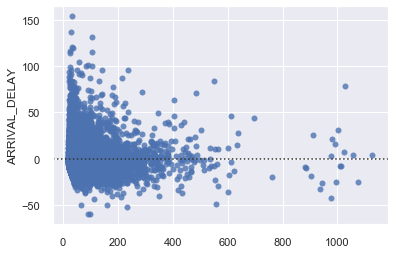

In [49]:
sns.residplot(pred, y_test)

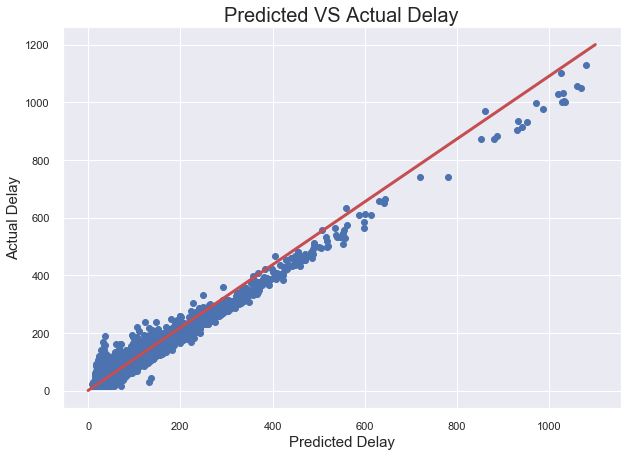

In [50]:
# Visualizing our Predictions vs Actual
pred = model.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((0,1100), (0, 1200), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

In [51]:
# Exporting model

# nn_filename = '../models/regression_nn_model.sav'
# pickle.dump(model, open(nn_filename, 'wb'))